## Air Quality Index: 5 Days Relative Mortality I

#### [Click to nbviewer](https://nbviewer.jupyter.org/github/Jerry-Tse/TimeSeries_AirQualityIndex/blob/master/Project_Air_Quality_1.ipynb) for some ploty graph cannot be seen in Github preview

### Table of Content

<font size="3">

* [Preparation: Packages, Reduce memory usage](#cell2)
<br><br>
* [Data Loading and preprocessing](#cell3)
<br><br>
* [Missing Value Description](#cell4)
<br><br>
* [Missing Value Imputation](#cell5)
<br><br>
* [Unit Scaling: Standardized the units of variables collected from different methods](#cell6)
<br><br>
* [Data Visualization: Hourly, Daily, Monthly basis](#cell7)


<a id="cell2"></a>

### Import Packages

In [18]:
#### Packages

import numpy as np
import pandas as pd
import time
import datetime
from statistics import mean
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import random
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

### Reduce numeric data memory usage

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="cell3"></a>

### First view of data

In [5]:
airdata = pd.read_csv("/Users/jerry/Downloads/AirQualityUCI/AirQualityUCI.csv", sep = ";")

def missing_table(input):
    total_temp = input.isnull().sum().sort_values(ascending = False)
    percent_miss_temp = (input.isnull().sum() / (len(airdata))*100).sort_values(ascending = False)
    airdata_missing = pd.concat([total_temp, percent_miss_temp], axis = 1 ,keys = ['total_missing', 'percent_missing(%)']) 
    return airdata_missing

display(missing_table(airdata))
display(airdata.tail(5))


,total_missing,percent_missing(%)
Unnamed: 16,9471,100.000000
Unnamed: 15,9471,100.000000
NOx(GT),114,1.203674
Time,114,1.203674
CO(GT),114,1.203674
PT08.S1(CO),114,1.203674
NMHC(GT),114,1.203674
C6H6(GT),114,1.203674
PT08.S2(NMHC),114,1.203674
PT08.S3(NOx),114,1.203674


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Concl. The missing value has already replaced with -200, these 114 null values are caused when loading csv, we can directly eliminate it.

### Load data with processing

In [6]:
def read_data(input_file):
    df = pd.read_csv(input_file, sep = ';', decimal = ",")
    df = df.iloc[0:9357, 0:15] ###to remove unnamed column 16 and 17
    df['Datetime'] = df["Date"].map(str)+ ' ' + df["Time"].map(str) 
    df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H.%M.%S') 
    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
    df['year'] = df['Datetime'].dt.year
    df['month'] = df['Datetime'].dt.month
    df['day'] = df['Datetime'].dt.day
    df['hour'] = df['Datetime'].dt.hour
    df['str_date'] = df["year"].map(str)+ '/' + df["month"].map(str) + '/'+  df["day"].map(str)
    return df

airdata = read_data("/Users/jerry/Downloads/AirQualityUCI/AirQualityUCI.csv")
airdata = reduce_mem_usage(airdata)

## rearrange the columns order
print('---------------------')
print(list(airdata.columns.values))
airdata = airdata[['Datetime',
                   'Date',
                   'Time',
                   'year',
                   'month',
                   'day',
                   'hour',
                   'CO(GT)',
                   'NMHC(GT)',
                   'C6H6(GT)',
                   'NOx(GT)',
                   'NO2(GT)',
                   'PT08.S1(CO)',
                   'PT08.S2(NMHC)',
                   'PT08.S3(NOx)',
                   'PT08.S4(NO2)',
                   'PT08.S5(O3)',
                   'T',
                   'RH',
                   'AH',
                   'str_date']]
display(airdata.head(5))

Mem. usage decreased to  0.56 Mb (62.5% reduction)
---------------------
['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Datetime', 'year', 'month', 'day', 'hour', 'str_date']


,Datetime,Date,Time,year,month,day,hour,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,str_date
0,2004-03-10 18:00:00,2004-03-10,18.00.00,2004,3,10,18,2.599609,150.0,11.898438,166.0,113.0,1360.0,1046.0,1056.0,1692.0,1268.0,13.601562,48.90625,0.757812,2004/3/10
1,2004-03-10 19:00:00,2004-03-10,19.00.00,2004,3,10,19,2.000000,112.0,9.398438,103.0,92.0,1292.0,955.0,1174.0,1559.0,972.0,13.296875,47.68750,0.725586,2004/3/10
2,2004-03-10 20:00:00,2004-03-10,20.00.00,2004,3,10,20,2.199219,88.0,9.000000,131.0,114.0,1402.0,939.0,1140.0,1555.0,1074.0,11.898438,54.00000,0.750000,2004/3/10
3,2004-03-10 21:00:00,2004-03-10,21.00.00,2004,3,10,21,2.199219,80.0,9.203125,172.0,122.0,1376.0,948.0,1092.0,1584.0,1203.0,11.000000,60.00000,0.786621,2004/3/10
4,2004-03-10 22:00:00,2004-03-10,22.00.00,2004,3,10,22,1.599609,51.0,6.500000,131.0,116.0,1272.0,836.0,1205.0,1490.0,1110.0,11.203125,59.59375,0.788574,2004/3/10


<a id="cell4"></a>

### Missing Values Description (replaced with -200)

#### 1. Amount of missing replaced with -200

In [7]:
total_airdata = airdata.applymap(lambda x: x == -200).sum().sort_values(ascending = False)
percent_miss_airdata = (total_airdata / np.array(airdata.apply(len)) *100)
airdata_missing = pd.concat([total_airdata, percent_miss_airdata], axis = 1 ,keys = ['total_missing', 'percent_missing(%)']) 
display(airdata_missing)

,total_missing,percent_missing(%)
NMHC(GT),8443,90.231912
CO(GT),1683,17.986534
NO2(GT),1642,17.548360
NOx(GT),1639,17.516298
RH,366,3.911510
T,366,3.911510
PT08.S5(O3),366,3.911510
PT08.S4(NO2),366,3.911510
PT08.S3(NOx),366,3.911510
PT08.S2(NMHC),366,3.911510


#### 2. Check if there are missings in DateTime 

In [8]:
temp = airdata['Date'].drop_duplicates()
temp = (temp.dt.year).astype(str) + '.' + (temp.dt.month).astype(str)
temp = pd.DataFrame(temp.value_counts()).reset_index().sort_values(by = 'index')
display(temp) ## each month are fully recorded, except first month and last month
print('Each month are fully recorded, except first month and last month')

temp = (pd.DataFrame(airdata.groupby('str_date').size(), columns = ['counts'])).reset_index()
display(temp[temp['counts'] != 24])  ## each day got 24 records(every hour), except first day and last time 
print('Each day got 24 records(every hour), except first day and last time ')

,index,Date
1,2004.10,31
10,2004.11,30
3,2004.12,31
12,2004.3,22
9,2004.4,30
4,2004.5,31
7,2004.6,30
2,2004.7,31
6,2004.8,31
8,2004.9,30


Each month are fully recorded, except first month and last month


,str_date,counts
92,2004/3/10,6
390,2005/4/4,15


Each day got 24 records(every hour), except first day and last time 


#### Concl. There have no missing in DateTime.

#### 3. The location of missing value: Heatmap

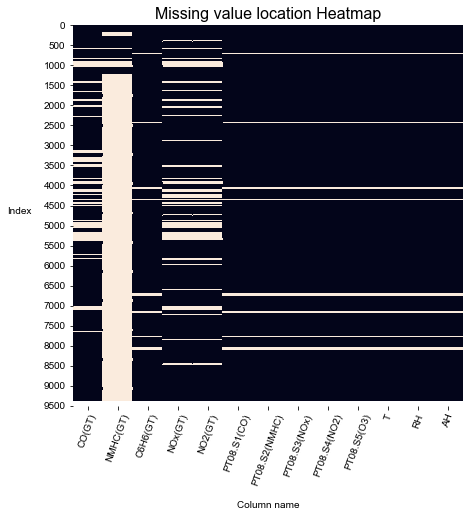

In [9]:
plt.figure(figsize=(7, 7))
fig = sns.heatmap(airdata.iloc[ : , 7:20 ].applymap(lambda x: x == -200), cbar=False,  yticklabels = np.arange(0, 10000, 500))
fig.yaxis.set_ticks(np.arange(0, 10000, 500))
fig.set_xticklabels(fig.get_xticklabels(), rotation = 70)
fig.set_title('Missing value location Heatmap', fontsize = 16)
plt.xlabel("Column name", labelpad=14)
plt.ylabel("Index", rotation=0, labelpad=24)
sns.set(font_scale=1.1)
plt.show()


#### Concl. The sensor's 366 missing value are in the same location.

#### 4. Missing at random or not

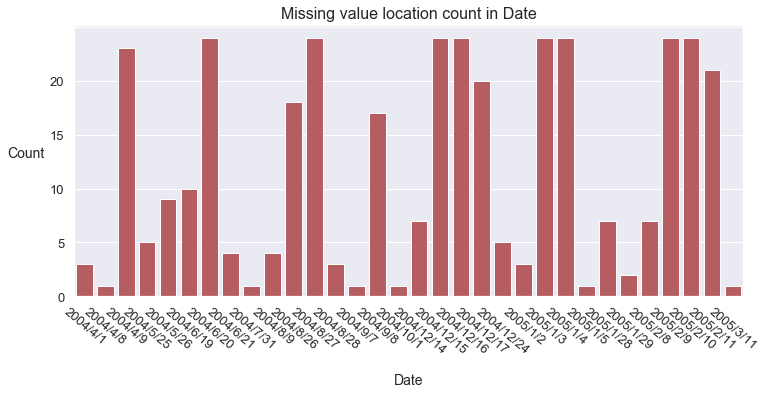

Includes eight days which are all-day-missing


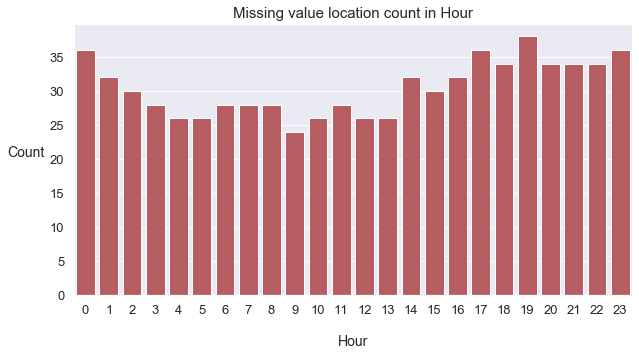

There is no hour specific on missing value


In [10]:
## Relationship with day
air_missing = airdata[airdata['PT08.S4(NO2)'] == -200]
temp = pd.DataFrame(air_missing['str_date'])
plt.figure(figsize=(12,5))
fig = sns.countplot(x='str_date', data=temp, palette=["C3"])
fig.set_title('Missing value location count in Date', fontsize = 16)
fig.set_xticklabels(list(air_missing['str_date'].drop_duplicates()), rotation=320, fontsize = 13)
fig.set_yticklabels(np.arange(0, 25, 5), fontsize = 13)
plt.xlabel("Date", labelpad=17, fontsize = 14)
plt.ylabel("Count", rotation=0, labelpad=24, fontsize = 14)
plt.show()

print('Includes eight days which are all-day-missing')

## Relationship with hour
temp = airdata[airdata['PT08.S4(NO2)'] == -200]
temp = pd.DataFrame(temp['hour'])
plt.figure(figsize=(10,5))
fig = sns.countplot(x="hour", data=temp, palette=["C3"])
fig.set_title('Missing value location count in Hour', fontsize = 15)
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 13)
fig.set_yticklabels(np.arange(0, 40, 5), fontsize = 13)
plt.xlabel("Hour", labelpad=17, fontsize = 14)
plt.ylabel("Count", rotation=0, labelpad=24, fontsize = 14)
plt.show()

print('There is no hour specific on missing value')



#### Concl. The data includes eight days which are all-day-missing, and missing values are not hour specific.
#### Concl. We can assume missing at random.

<a id="cell5"></a>

### Missing values imputation   

Missing values treatments:
* There are mainly two ways that I am considering. First way is to use the sequential hours within the day, and second one is to use the same hour in sequential days. For example, if the missing occurred at 5:00 4th.May, then the first solution will take the data recorded at 3:00, 4:00, 6:00 and 7:00 on 4th.May, and the second one will use 5:00 on 2nd.May, 3rd.May, 5th.May and 6th.May for imputation.
    
    
* Although KNN are getting popular in imputing missing values, it might not be the good choice in this case, because the location of missing values are highly consistent in factor X(the heatmap above), it is also not recommended to break the time series and use only physical distance of each value to determine the relationship.
    
    
* I also eliminate the whole day data if there are more than 12 missings within that day, because it is quite unreasonable if the data within a day are all imputed.

#### 1. Delete the day with more than 12 missing values 

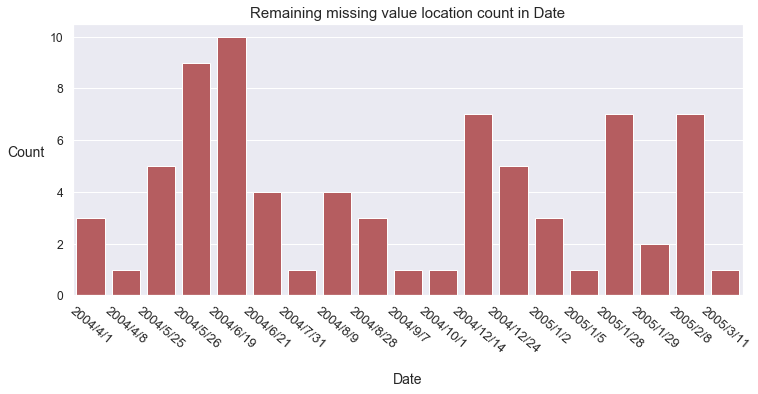

In [11]:
temp = airdata[airdata['PT08.S4(NO2)'] == -200]
temp = temp['Date'].value_counts()
temp = (temp[temp > 12]).index
airdata = airdata[~airdata['Date'].isin(temp)]
# airdata[airdata['PT08.S4(NO2)'] == -200]['Date'].value_counts()    # can directly view the remaining missing amount
temp = airdata[airdata['PT08.S4(NO2)'] == -200]

## Visualize the remaining data
plt.figure(figsize=(12,5))
fig = sns.countplot(x="Date", data=temp, palette=["C3"])
fig.set_title('Remaining missing value location count in Date', fontsize = 15)
fig.set_xticklabels(list(temp['str_date'].drop_duplicates()), rotation=320, fontsize = 13)
plt.xlabel("Date", labelpad=17, fontsize = 14)
plt.ylabel("Count", rotation=0, labelpad=24, fontsize = 14)
plt.show()


#### 2. Pollution status in same hour regardless of day 

Replace with lst = list(range(24)) if you wish to see all hours.

In [12]:
## NO2
lst = [2,8,14,19]   ## replace with lst = list(range(24)) if you wish to see all hours.
for x in lst: 
    temp = airdata[airdata['hour'] == x]
    temp1 = temp['PT08.S4(NO2)']
    time = temp['str_date']
    
    trace = go.Scatter(x = time, 
                       y = temp1, 
                       name= 'PT08.S4(NO2)')
    
    layout = go.Layout(dict(title = "NO2 amount at"+' '+ str(x)+ ':00 '+ "regardless of days",                            
                            width=800,
                            height=350,
                            margin=go.layout.Margin(
                                l=80,
                                r=80,
                                b=90,
                                t=70,),
                            xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =30.0, tickangle=30),
                            yaxis = dict(title = 'Concentration', range = [500, 3000]),
                            ),legend=dict(
        orientation="v"))
    dataPanda = []
    dataPanda.append(trace)
    py.iplot(dict(data=dataPanda, layout=layout))
    plt.show()

Replace with lst = list(range(24)) if you wish to see all hours.

In [16]:
## O3
lst = [2,8,14,19]   ## replace with lst = list(range(24)) if you wish to see all hours.
for x in lst:  
    temp = airdata[airdata['hour'] == x]
    temp1 = temp['PT08.S5(O3)']
    time = temp['str_date']

    trace = go.Scatter(x = time, 
                       y = temp1, 
                       name= 'PT08.S5(O3)')
    
    layout = go.Layout(dict(title = "O3 amount at"+' '+ str(x)+ ':00 '+ "regardless of days",
                            width=800,
                            height=350,
                            margin=go.layout.Margin(
                                l=80,
                                r=80,
                                b=90,
                                t=70,),
                            xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =30.0, tickangle=30),
                            yaxis = dict(title = 'Concentration', range = [0, 2500]),
                            ),legend=dict(
        orientation="v"))    
    dataPanda = []
    dataPanda.append(trace)
    py.iplot(dict(data=dataPanda, layout=layout))
    plt.show()

#### Concl. Based on the figure above, I decided to use same hour within sequential days to impute the missings because of the difference in concentration in different hours. (the dramatic drop in the figure is due to the missing values -200)

#### 3. Impute the missing values with the mean of the same hour in 5 sequential days.

In [19]:
## NO2 and O3
index = (airdata[airdata['PT08.S4(NO2)'] == -200]).index.to_list()

for x in index:
    lst = [x-48,x-24,x+24,x+48]
    airdata['PT08.S4(NO2)'][x] = (airdata['PT08.S4(NO2)'][lst]).mean()
    airdata['PT08.S5(O3)'][x]  = (airdata['PT08.S5(O3)'][lst]).mean()

display(airdata[airdata['PT08.S4(NO2)'] == -200])


,Datetime,Date,Time,year,month,day,hour,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,str_date


#### Concl. Finish the imputation, no more missing values.

<a id="cell6"></a>

### Scaling the units of PT and GT

* As mentioned in READ.me, we need to scale the unknown unit of PT with the known unit of GT, so that we can quantify the relationship between mortality and air pollutant.
    
    
* The first scatter plot shows that there have no linear relationship in PT and GT.
    
    
* As we already know, the truth recording situation of PT and GT are actually at the same time but in differernt places(PT: road based in city center, GT: traditional air quality monitor station), which might lead to some time delay due to the pollutant diffusion from city center to monitor station(I have proved the pollutant are mainly caused by human activity, see the graph of hourly basis in Data Visualization).
    
    
* Based on the tendency of time delay in point three, I took out the middle 50% data of GT and PT, sorted and drew the scatter plot to find the regression line, this method view the data as a range, just like the way we transform Fahrenheit and Celsius.
    
    
* To be noted, the regression line need to be shifted by adding some intercepy because the concentration descent when diffusion. But I have no any reference for doing this.
    
    
* The reason why we take no action to the outliers (outliers can be seen in violin plot below) is answered in Data Visualization-Daily basis.

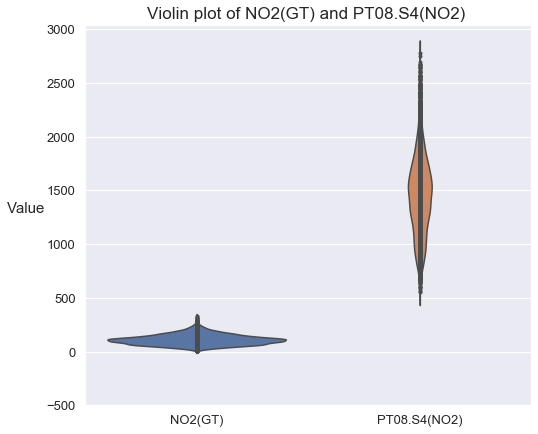

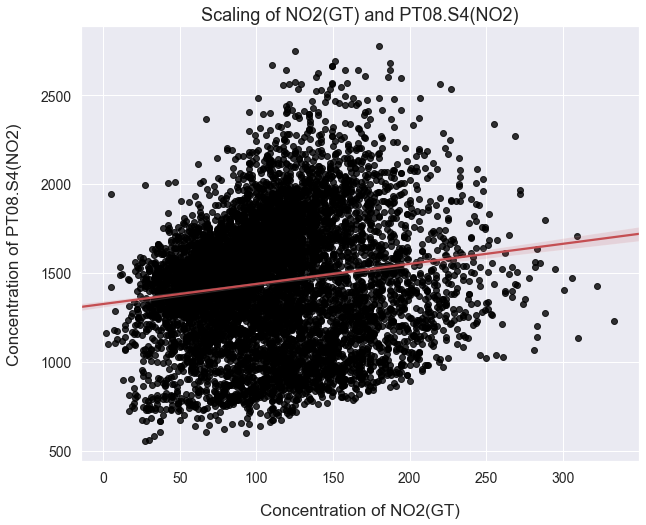

In [20]:
## Violin plot
plt.figure(figsize=(8, 7))
air_temp = airdata[['NO2(GT)','PT08.S4(NO2)']]
air_temp = air_temp[air_temp['NO2(GT)'] > -200]
sns.violinplot(data=air_temp, inner="points")
plt.title('Violin plot of NO2(GT) and PT08.S4(NO2) ', fontsize = 17)
plt.ylabel('Value', fontsize = 15, labelpad = 20, rotation = 0)
plt.yticks(np.arange(-500, 3100, 500), fontsize = 13)
plt.xticks(fontsize = 13)
plt.show()

## Scatter plot
air_temp = air_temp[air_temp['NO2(GT)'] > -200]
plt.figure(figsize=(10, 8))
sns.regplot(x=air_temp['NO2(GT)'], 
            y = air_temp['PT08.S4(NO2)'], 
            scatter_kws={'color': sns.xkcd_rgb['black']}, 
            line_kws={"color":"r"})
plt.xlabel('Concentration of NO2(GT)', fontsize = 17, labelpad = 18)
plt.ylabel('Concentration of PT08.S4(NO2)', fontsize = 17, labelpad = 18)
plt.title('Scaling of NO2(GT) and PT08.S4(NO2)', fontsize = 18)
plt.xticks(np.arange(0, 350, 50), fontsize = 14)
plt.yticks(np.arange(500, 3000, 500), fontsize = 14)
plt.show()


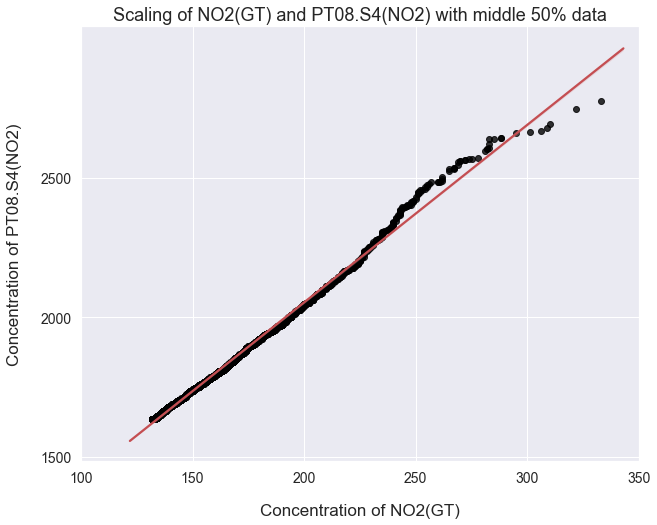

Linear regression with coefficient:  [[0.15632704]]
Linear regression with intercept:  [-121.11197]


In [21]:
#### Scaling PT and GT

## Middle 50% (25%~75%)
## instead of using percentage, we can only use exact amount here, because percentage won't create equal length
air_temp = airdata[airdata['NO2(GT)'] > -200]
air_GT = air_temp['NO2(GT)']
air_PT = air_temp['PT08.S4(NO2)']

def middle_50(series):
    mean = series.mean()
    
    high = series[series > mean]
    high = high.sort_values(ascending = False).tail(2250)
    low = series[series <= mean]
    low = low.sort_values(ascending = False).head(2250)
    
    out = pd.concat([high, low], ignore_index=True)
    return out

arranged = pd.concat([middle_50(air_GT), middle_50(air_PT)], axis=1)

## Visualization
plt.figure(figsize=(10, 8))
sns.regplot(x=arranged['NO2(GT)'], y = arranged['PT08.S4(NO2)'], scatter_kws={'color': sns.xkcd_rgb['black']}, line_kws={"color":"r"})
plt.xlabel('Concentration of NO2(GT)', fontsize = 17, labelpad = 18)
plt.ylabel('Concentration of PT08.S4(NO2)', fontsize = 17, labelpad = 18)
plt.title('Scaling of NO2(GT) and PT08.S4(NO2) with middle 50% data', fontsize = 18)
plt.xticks(np.arange(100, 400, 50), fontsize = 14)
plt.yticks(np.arange(1500, 3000, 500), fontsize = 14)
plt.show()

## Transform NO2
regressor = LinearRegression()  
regressor.fit(np.array(arranged['PT08.S4(NO2)']).reshape(-1, 1), np.array(arranged['NO2(GT)']).reshape(-1, 1))
print('Linear regression with coefficient: ' , regressor.coef_)
print('Linear regression with intercept: ' , regressor.intercept_)

airdata['adj_NO2 (μg/m3)'] = (airdata['PT08.S4(NO2)'].apply(lambda x: x * 0.15632704 - 121.11197))

### we suppose to add intercept, because the road based is supposed to be higher than station data
### but we have no any data to do this


<a id="cell7"></a>

### Data Visualization

#### 1. Hourly basis

* Take out hour of top3 and min3 pollutant concentration occured in each days and make counts.

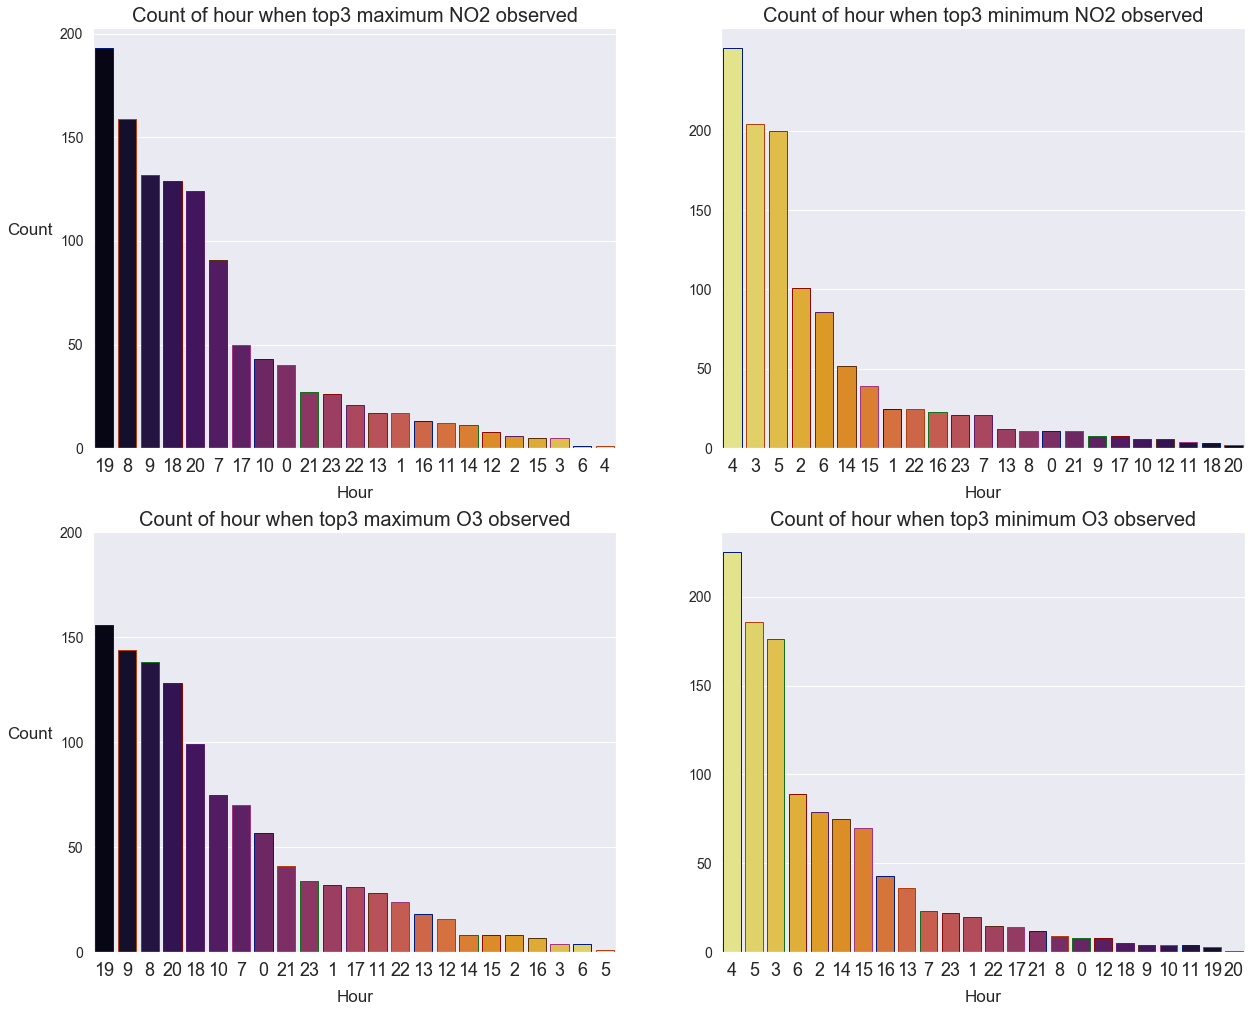

In [24]:
#### NO2 and O3 hour count
temp = airdata[['str_date', 'PT08.S4(NO2)','PT08.S5(O3)','hour']][6:9342]  ## eliminate first and last days(incomplete)
lst = temp['str_date'].drop_duplicates().to_list()

datastore_N_head = []
datastore_N_tail = []
datastore_O_head = []
datastore_O_tail = []

for x in lst:
    NO2 = temp[temp['str_date'] == x].sort_values(by = 'PT08.S4(NO2)', ascending = False)
    count = NO2.head(3)['hour'].to_list()
    datastore_N_head.extend(count)
    count = NO2.tail(3)['hour'].to_list()
    datastore_N_tail.extend(count)
    
    O3 = temp[temp['str_date'] == x].sort_values(by = 'PT08.S5(O3)', ascending = False)
    count = O3.head(3)['hour'].to_list()
    datastore_O_head.extend(count)
    count = O3.tail(3)['hour'].to_list()
    datastore_O_tail.extend(count)
    
def get_order(list):
    temp = pd.DataFrame(list)
    temp = temp.iloc[:, 0].value_counts().sort_values(ascending = False).index
    return temp

plt.figure(figsize=(20, 17))
plt.subplots_adjust(left=0.1)

plt.subplot(221)
fig = sns.countplot(x=datastore_N_head, order = get_order(datastore_N_head), palette='inferno',edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('Count', fontsize = 17, rotation = 0, labelpad = 30)
plt.title('Count of hour when top3 maximum NO2 observed', fontsize = 20)

plt.subplot(223)
fig = sns.countplot(x=datastore_O_head, order = get_order(datastore_O_head), palette='inferno',edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('Count', fontsize = 17, rotation = 0, labelpad = 30)
plt.title('Count of hour when top3 maximum O3 observed', fontsize = 20)

plt.subplot(222)
fig = sns.countplot(x=datastore_N_tail, order = get_order(datastore_N_tail), palette='inferno_r', edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('')
plt.title('Count of hour when top3 minimum NO2 observed', fontsize = 20)

plt.subplot(224)
fig = sns.countplot(x=datastore_O_tail, order = get_order(datastore_O_tail), palette='inferno_r',edgecolor=sns.color_palette('dark',7))
fig.set_xticklabels(fig.get_xticklabels(), fontsize = 18)
plt.yticks(np.arange(0, 250, 50), fontsize = 14)
plt.xlabel('Hour', fontsize = 17,  labelpad = 10)
plt.ylabel('')
plt.title('Count of hour when top3 minimum O3 observed', fontsize = 20)
plt.show()


#### Concl. The highest concentration can be seen at rush hours for work, and the lowest concentration occured at midnight. This might infer the concentration are highly related to human activity.

#### 2. Daily basis

* Daily max, average and min on NO2

In [34]:
mean = airdata.groupby(['Date']).mean()
max = airdata.groupby(['Date']).max()
min = airdata.groupby(['Date']).min()

air_temp[['year','month','day']] = air_temp[['year','month','day']].astype(int).astype(str)

time = air_temp["year"] + '/' + air_temp["month"] + '/'+  air_temp["day"]
time = time.drop_duplicates()

trace1 = go.Scatter(x = time, y = max['PT08.S4(NO2)'], name= 'PT(NO2) Max')
trace2 = go.Scatter(x = time, y = mean['PT08.S4(NO2)'], name= 'PT(NO2) Mean')
trace3 = go.Scatter(x = time, y = min['PT08.S4(NO2)'], name= 'PT(NO2) Min', marker=dict(color='#851e52'))

layout = go.Layout(dict(title = "Time Series of Daily average",
                        width=1000,
                        height=500,
                        xaxis = dict( range = ['2004-03-01','2005-04-01'],  tick0 = 4.0, dtick =30.0, tickangle=45),
                        yaxis = dict(title = 'Concentration', range = [500, 3000]),
                        ),legend=dict(
    orientation="v"))

dataPanda = []

dataPanda.append(trace1)
dataPanda.append(trace2)
dataPanda.append(trace3)
py.iplot(dict(data=dataPanda, layout=layout))
plt.show()

#### Concl. In the figure above, we can see the range of daily max is much wider than daily average and daily min. 

#### Concl. If you look at the violin plot above, you might be curious about why I didn't take any action toward the outliers, this is because that based on the formula 1.5 times of IQR, the daily max with such wide range have high probability to be regarded as outliers. But in real world, I believe it is reasonable to have such a wide variation if you detect the pollutant directly aside the road.

#### 3. Monthly basis (monthly average)

* Monthly average of NO2 and O3

In [36]:
air_temp = airdata.copy()
air_temp[['year','month','day']] = air_temp[['year','month','day']].astype(int).astype(str)
air_temp['str_month'] = air_temp["year"] + '/' + air_temp["month"]
air_temp = air_temp.groupby(['str_month'])[['PT08.S5(O3)','PT08.S4(NO2)']].mean()

air_temp.index
air_temp = air_temp.reindex(['2004/3', '2004/4', '2004/5', '2004/6', '2004/7', '2004/8', '2004/9', 
                             '2004/10', '2004/11', '2004/12', '2005/1', '2005/2', '2005/3', '2005/4'])

time = air_temp.index

trace1 = go.Scatter(x = time, y = air_temp['PT08.S5(O3)'], name= 'PT(O3)')
trace2 = go.Scatter(x = time, y = air_temp['PT08.S4(NO2)'], name= 'PT(NO2)')

layout = go.Layout(dict(title = 'Time Series of Monthly mean on NO2 and O3',
                        width=800,
                        height=500,
                        xaxis = dict( range = ['2004-03','2005-04'],  tick0 = 0.0, dtick =1.0),
                        yaxis = dict(title = 'Concentration', range = [500, 2000]),
                        ),legend=dict(
    orientation="v"))

dataPanda = []
dataPanda.append(trace1)
dataPanda.append(trace2)
py.iplot(dict(data=dataPanda, layout=layout))
plt.show()

#### Concl. A dramatic drop in NO2 can be seen in winter season.

#### Concl. Season, year and hour plays important role in pollutant concentration.

### Write data

In [26]:
import os
os.chdir('/Users/jerry/Desktop/') ## your directory
airdata.to_csv('airdata_processed.csv')